In [1]:
# Make sure that you have all these libaries available to run the code successfully

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler

import requests # Retrieve data
import json 



This project is to replicate result from ```https://www.datacamp.com/tutorial/lstm-python-stock-market``` and improve it based on my further research. 

# Data (Alpha Vantasge Stock API)

I will use 20 years of historical data for American Airlines stock. 

Get API key from here ```https://www.alphavantage.co/support/#api-key``` : ```NMHEQ0BIWNYCAQOF```

In [2]:
# ====================== Loading Data from Alpha Vantage ==================================

api_key = 'NMHEQ0BIWNYCAQOF'

# American Airlines stock market prices
ticker = "AAL"

# JSON file with all the stock market data for AAL from the last 20 years
url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

# Save data to this file
file_to_save = 'stock_market_data-%s.csv'%ticker

# If you haven't already saved data,
# Go ahead and grab the data from the url
# And store date, low, high, volume, close, open values to a Pandas DataFrame
if not os.path.exists(file_to_save):
    with urllib.request.urlopen(url_string) as url:
        data = json.loads(url.read().decode())
        # extract stock market data
        data = data['Time Series (Daily)']
        df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
        for k,v in data.items():      # key  variable in the
            date = dt.datetime.strptime(k, '%Y-%m-%d')
            data_row = [date.date(),float(v['3. low']),float(v['2. high']),  #.date() remove hours
                        float(v['4. close']),float(v['1. open'])]
            df.loc[-1,:] = data_row
            df.index = df.index + 1
    print('Data saved to : %s'%file_to_save)        
    df.to_csv(file_to_save)

# If the data is already there, just load it from the CSV
else:
    print('File already exists. Loading data from CSV')
    df = pd.read_csv(file_to_save)


File already exists. Loading data from CSV


In [3]:
# Sort DataFrame by date
df = df.sort_values('Date').reset_index(drop=True)
df = df.drop(columns=['Unnamed: 0'])
# Double check the result
df.head()

,Date,Low,High,Close,Open
0,2005-09-27,19.10,21.40,19.30,21.05
1,2005-09-28,19.20,20.53,20.50,19.30
2,2005-09-29,20.10,20.58,20.21,20.40
3,2005-09-30,20.18,21.05,21.01,20.26
4,2005-10-03,20.90,21.75,21.50,20.90


Visualize mid data

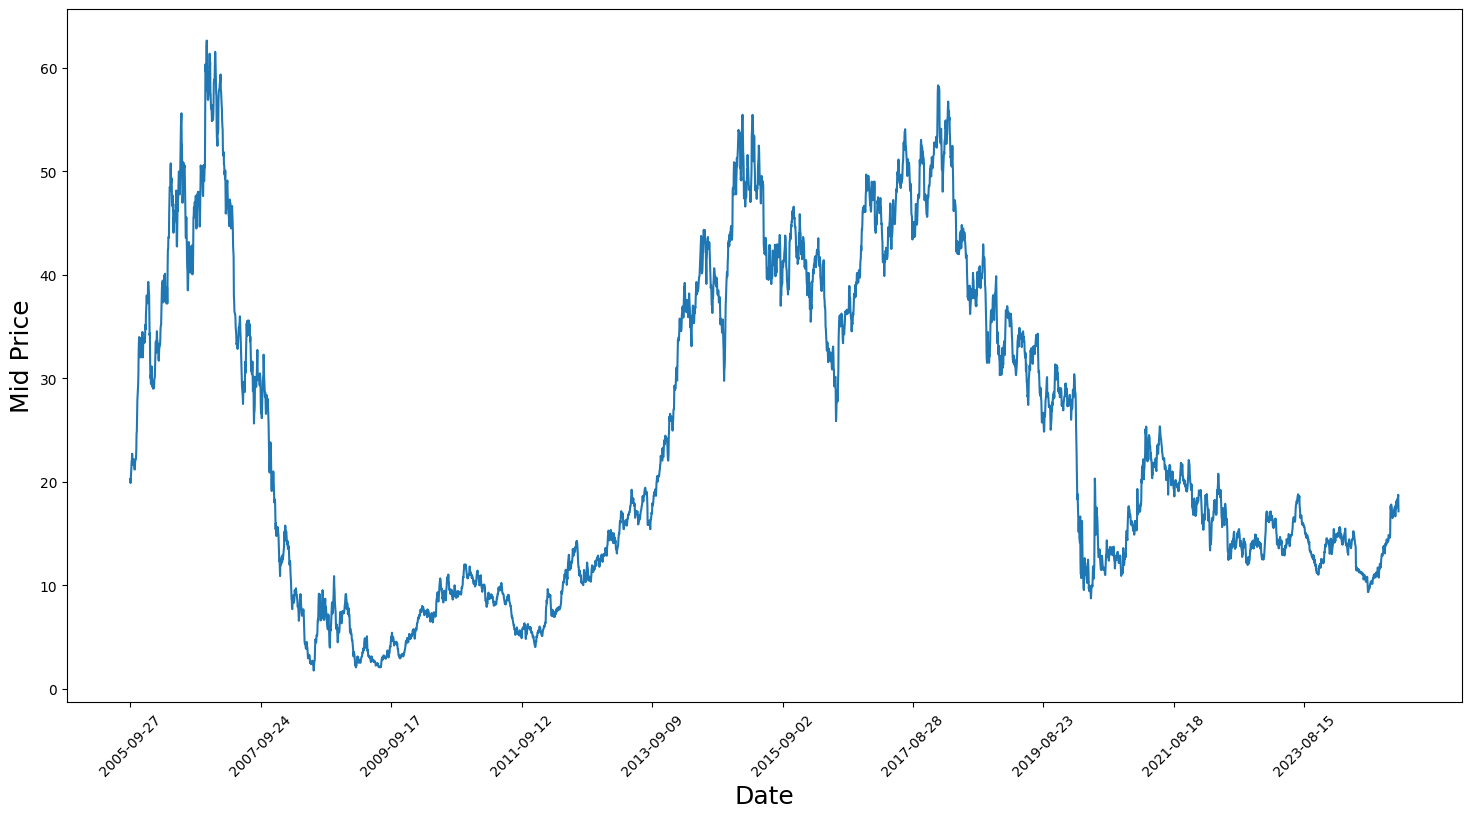

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),(df['Low']+df['High'])/2.0)
plt.xticks(range(0,df.shape[0],500),df['Date'].loc[::500],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

Orginal code ```.as_matrix()``` but this code is not available, hence I use ```.to_numpy()```

In [4]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df['Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0


print("High prices:", high_prices.shape)
print("Low prices:", low_prices)
print("Mid prices:", mid_prices)

High prices: (4862,)
Low prices: [19.1  19.2  20.1  ... 18.27 18.37 16.73]
Mid prices: [20.25  19.865 20.34  ... 18.46  18.735 17.133]


In [5]:
cutline = (int(df.shape[0]*0.9)//100)*100
print(cutline)
train_data = mid_prices[:cutline]
test_data = mid_prices[cutline:]


4300


Normalize the data for better performance when using lstm. We normalize the data by splitting the full series into windows because data have different variation over time windows. 

When choosing the window size, make sure it's not too small. I think two points are enough since I am using data from 2005. 

In [6]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()  #initiate before using scaler.fit
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)


In [ ]:
# Train the Scaler with training data and smooth data
smoothing_window_size = 2000
for di in range(0,4000,smoothing_window_size):
    print(di)
    scaler.fit(train_data[di:di+smoothing_window_size,:]) # This fits the scaler to the current chunk of data.
    train_data[di:di+smoothing_window_size,:] = scaler.transform(train_data[di:di+smoothing_window_size,:])

# You normalize the last bit of remaining data
scaler.fit(train_data[di+smoothing_window_size:,:])
train_data[di+smoothing_window_size:,:] = scaler.transform(train_data[di+smoothing_window_size:,:])


# scaler.transform makes mean 0 and sd = 1

0
2000


Reshape the data back to the shape of [data_size]

In [58]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
print(train_data.shape)
# Normalize test data
test_data = scaler.transform(test_data).reshape(-1)

(4300,)


Exercise 1: Try to predict the future stock price as an average of the previosuly observed stock prices within a fixed size window. We are using an idea of the martingale. 

For time series data, it is natural to think about ```differencing``` and ```smoothing``` to eliminate the inherent nosiy fluctuation of stock prices and produce a smoother curve. 

In [8]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0    # (exponential moving averaage)
gamma = 0.1
n = len(train_data)
for ti in range(n):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA  
  # This formula calculates the weighted average of current data point
  # and previous EMA value, where gamma is the wieght given to current data point and 1-gamma to previous EMA value. 
  train_data[ti] = EMA

# Used for visualization and test purposes   it makes single array 
all_mid_data = np.concatenate([train_data,test_data],axis=0) 

Now try one-step ahead prediction via average. Note that using the idea of martingale is restricted to one time step ahead. I will call this  ```standard average```. 

In [10]:
window_size = 100
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))


MSE error for standard averaging: 0.00470


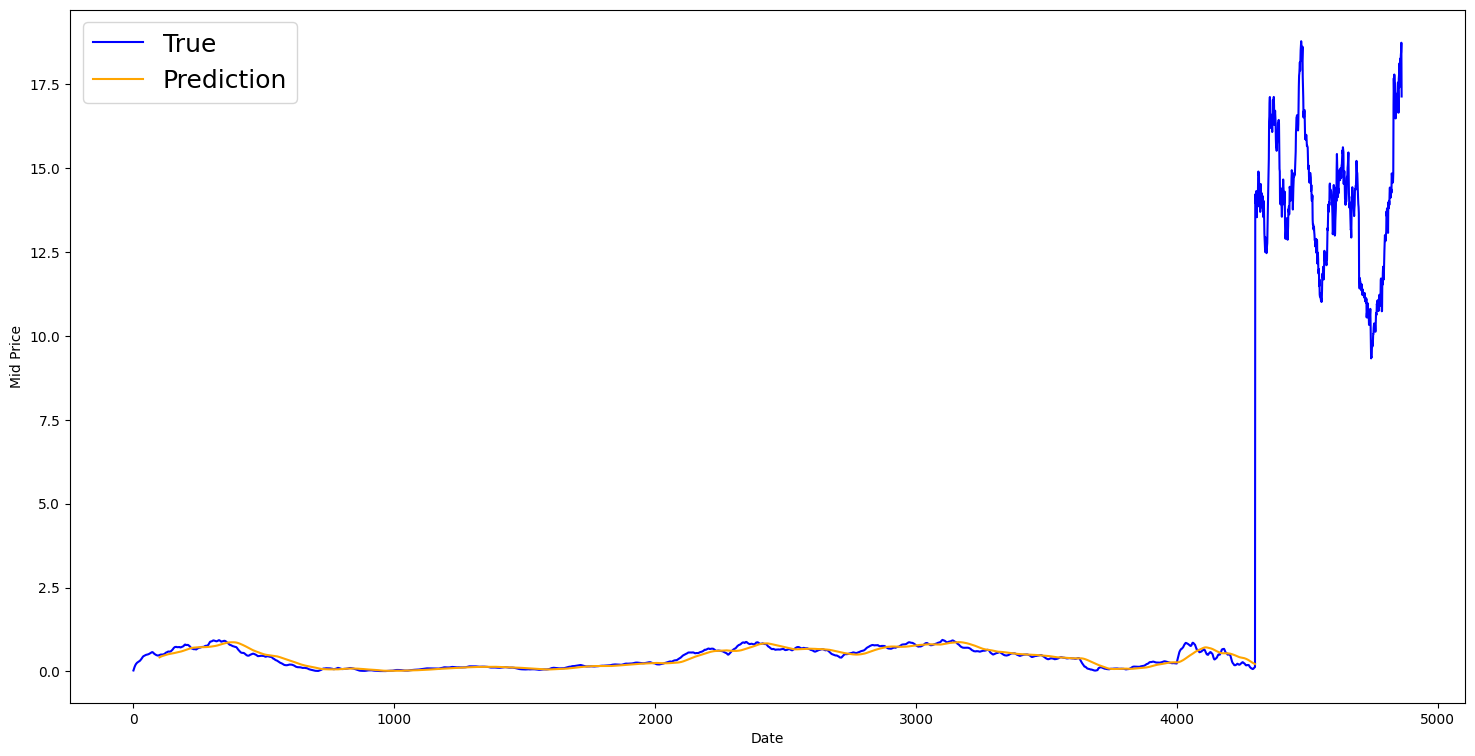

In [13]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

It seems that it is not too bad of a model for very short predictions (one day ahead). This behavior is sensible since stock prices don't change from 0 to 100 overnight. Next, you will look at a fancier averaging technique, the exponential moving average.

In the exponential moving average method, you calculate $x_{t+1}$ as,

$x_{t+1} = EMA_{t} = \gamma \times EMA_{t-1} + (1-\gamma) x_t$ where $EMA_0 = 0$ and $EMA$ is the exponential moving average value you maintain over time.
The above equation basically calculates the exponential moving average from $t+1$ time step and uses that as the one step ahead prediction. $\gamma$ decides what the contribution of the most recent prediction is to the EMA. For example, a $\gamma=0.1$ gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. See how good this looks when used to predict one-step ahead below.

In [16]:
window_size = 100
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1, N):
    running_mean = running_mean * decay + (1.0 - decay) * train_data[pred_idx - 1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1] - train_data[pred_idx]) ** 2)
    run_avg_x.append(df.loc[pred_idx, 'Date'])

print('MSE error for EMA averaging: %.5f' % (0.5 * np.mean(mse_errors)))


MSE error for EMA averaging: 0.00004


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4300,) + inhomogeneous part.

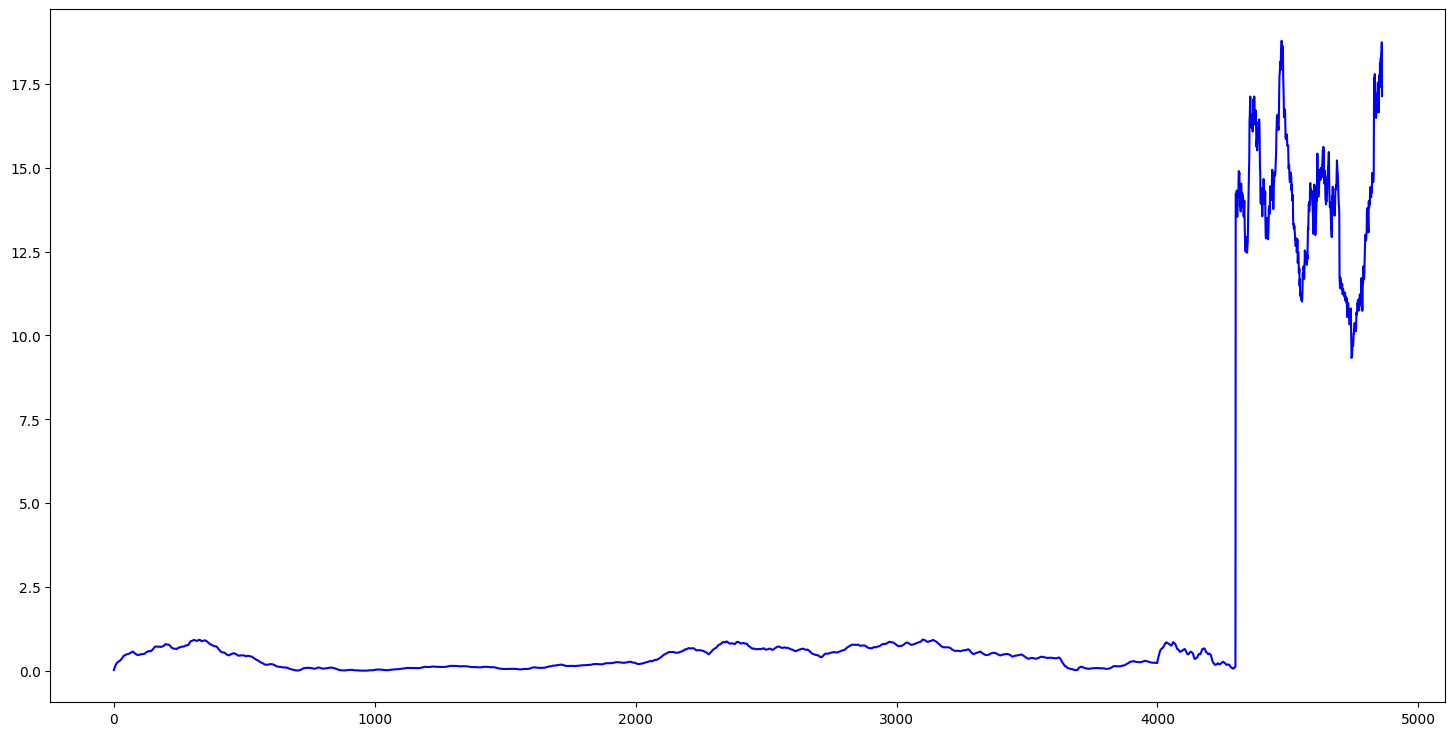

In [17]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()